# Healthcare Spending Analysis: Cross-Temporal Comparison 1991-2020

## Introduction

This notebook presents a comprehensive analysis of healthcare spending patterns across the United States, combining data from four distinct time periods: **1991, 2000, 2010, and 2020**. By merging these previously separate datasets from the Kaiser Family Foundation (KFF), we create a longitudinal view of healthcare spending evolution over three decades.

### Purpose and Scope
The analysis aims to:
- Track changes in per capita healthcare spending across all U.S. states over a 30-year period.
- Identify long-term trends and regional patterns in healthcare expenditure.
- Quantify and visualize the growth in healthcare costs across different regions.
- Highlight states with notable spending patterns or significant changes.

### Data Source
Our data comes from the Kaiser Family Foundation's **Health Expenditures by State of Residence** series, which provides:
- Per capita healthcare spending for all 50 states and the District of Columbia.
- Data points from four specific years: **1991, 2000, 2010, and 2020**.
- Comprehensive coverage of both public and private healthcare spending.
- Standardized measurements across all time periods.

### Methodology
This notebook implements several key analytical steps:

1. **Data Integration**:
   - Combines four separate KFF datasets into a unified analysis framework.
   - Standardizes monetary values and state identifiers across all years.
   - Creates a longitudinal dataset for trend analysis.

2. **Analysis Components**:
   - Statistical analysis of spending patterns.
   - Calculation of growth rates and spending changes.
   - Regional comparisons and state-level rankings.
   - Visualization of trends and distributions.

3. **Metrics Examined**:
   - Total change in spending over the 30-year period.
   - Compound Annual Growth Rate (CAGR).
   - Regional variations and state-specific patterns.
   - Distribution of spending across states and time periods.

This analysis serves as a valuable tool for policymakers, healthcare administrators, and researchers interested in understanding the long-term evolution of healthcare spending in the United States.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set plotting styles
plt.style.use('seaborn-v0_8')
sns.set_theme()
sns.set_palette("husl")

# Define base directory and file paths
base_dir = '../data/raw'
years = [1991, 2000, 2010, 2020]
file_paths = {
    year: os.path.join(base_dir, f'kff_healthcare_spending_per_capita_{year}.csv')
    for year in years
}

In [2]:
def prepare_year_data(filepath: str, year: int) -> pd.DataFrame:
    """
    Clean and prepare data for a specific year.
    
    Parameters:
    - filepath: Path to the CSV file
    - year: Year of the data
    
    Returns:
    - Cleaned DataFrame with year column
    """
    df = pd.read_csv(filepath, skiprows=2)  # Skip title and timeframe rows
    df = df.dropna(subset=['Location'])  # Drop rows where 'Location' is NaN
    df = df[df['Location'].str.strip() != '']  # Remove empty rows
    df['Health Spending per Capita'] = df['Health Spending per Capita'].str.replace('$', '').str.replace(',', '').astype(float)
    df['Year'] = year
    return df

In [3]:
# Create DataFrames for each year
dfs = []
for year in years:
    try:
        df = prepare_year_data(file_paths[year], year)
        dfs.append(df)
        print(f"Successfully loaded data for {year}")
    except Exception as e:
        print(f"Error loading {year} data: {e}")

# Combine all years into a single DataFrame
df_combined = pd.concat(dfs, axis=0)

# Check for duplicates
if df_combined.duplicated(['Location', 'Year']).any():
    print("Warning: Duplicate entries found")
    df_combined = df_combined.drop_duplicates(['Location', 'Year'])

Successfully loaded data for 1991
Successfully loaded data for 2000
Successfully loaded data for 2010
Successfully loaded data for 2020


In [ ]:
df_pivot = df_combined.pivot_table(
    index='Location', 
    columns='Year', 
    values='Health Spending per Capita',
    aggfunc='first'  # Handle duplicates by taking the first occurrence
)

# Calculate metrics
df_pivot['Total_Change'] = df_pivot[2020] - df_pivot[1991]
df_pivot['Pct_Change'] = ((df_pivot[2020] - df_pivot[1991]) / df_pivot[1991] * 100).round(1)
df_pivot['CAGR'] = ((df_pivot[2020] / df_pivot[1991]) ** (1/29) - 1) * 100

# Display the first 5 values from the pivot table
df_pivot.head()


Year,1991,2000,2010,2020,Total_Change,Pct_Change,CAGR
Location,,,,,,,
Alabama,2523.0,3921.0,6406.0,9280.0,6757.0,267.8,4.593455
Alaska,2553.0,4559.0,8927.0,13642.0,11089.0,434.4,5.949153
Arizona,2434.0,3225.0,6020.0,8756.0,6322.0,259.7,4.513382
Arkansas,2351.0,3709.0,6378.0,9338.0,6987.0,297.2,4.870953
California,2659.0,3567.0,6480.0,10299.0,7640.0,287.3,4.780027


In [5]:
print("\nMean Spending by Year:")
for year in years:
    mean_spending = df_combined[df_combined['Year'] == year]['Health Spending per Capita'].mean()
    print(f"{year}: ${mean_spending:,.2f}")

print("\nGrowth Analysis")
us_data = df_pivot.loc['United States']
print(f"Total US Change: ${us_data['Total_Change']:,.2f}")
print(f"US Percentage Change: {us_data['Pct_Change']:.1f}%")
print(f"US CAGR: {us_data['CAGR']:.1f}%")


Mean Spending by Year:
1991: $2,590.31
2000: $4,141.56
2010: $7,265.06
2020: $10,471.58

Growth Analysis
Total US Change: $7,532.00
US Percentage Change: 283.3%
US CAGR: 4.7%


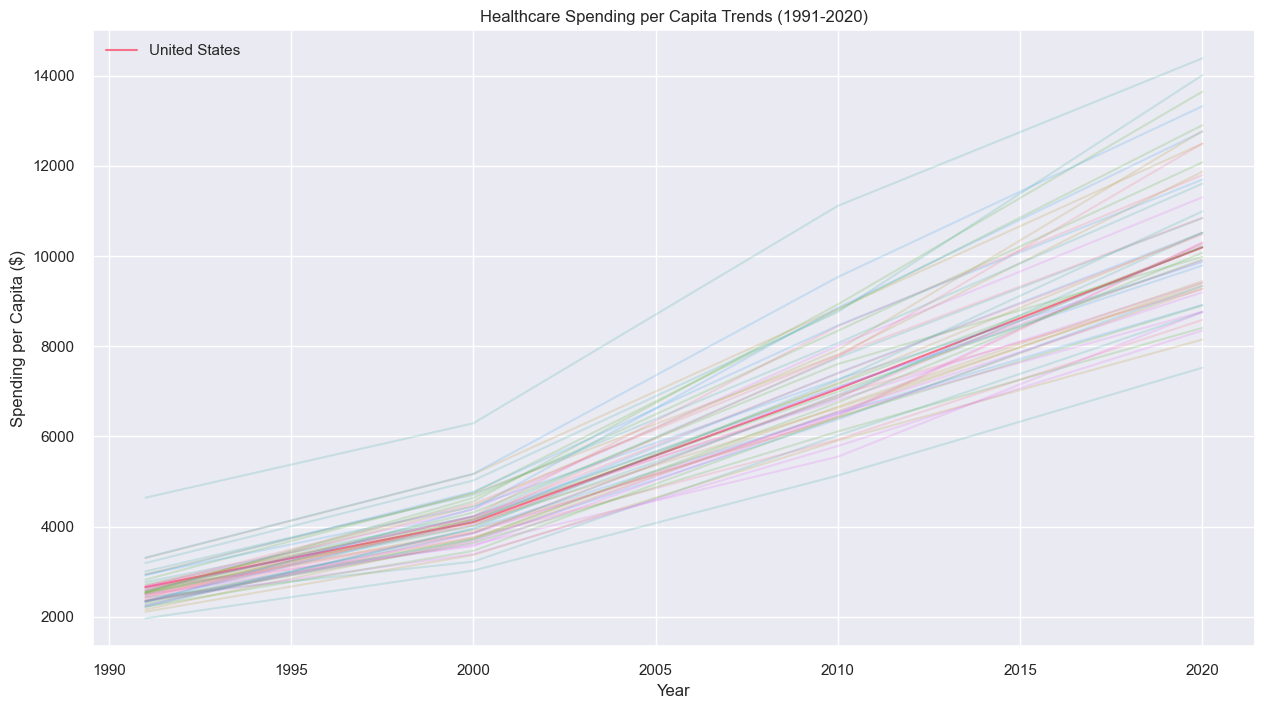

In [6]:
plt.figure(figsize=(15, 8))
for location in ['United States'] + list(df_pivot.index[df_pivot.index != 'United States']):
    plt.plot(df_pivot.loc[location, years], alpha=0.2 if location != 'United States' else 1.0, label=location if location == 'United States' else None)
plt.title('Healthcare Spending per Capita Trends (1991-2020)')
plt.xlabel('Year')
plt.ylabel('Spending per Capita ($)')
plt.legend()
plt.show()

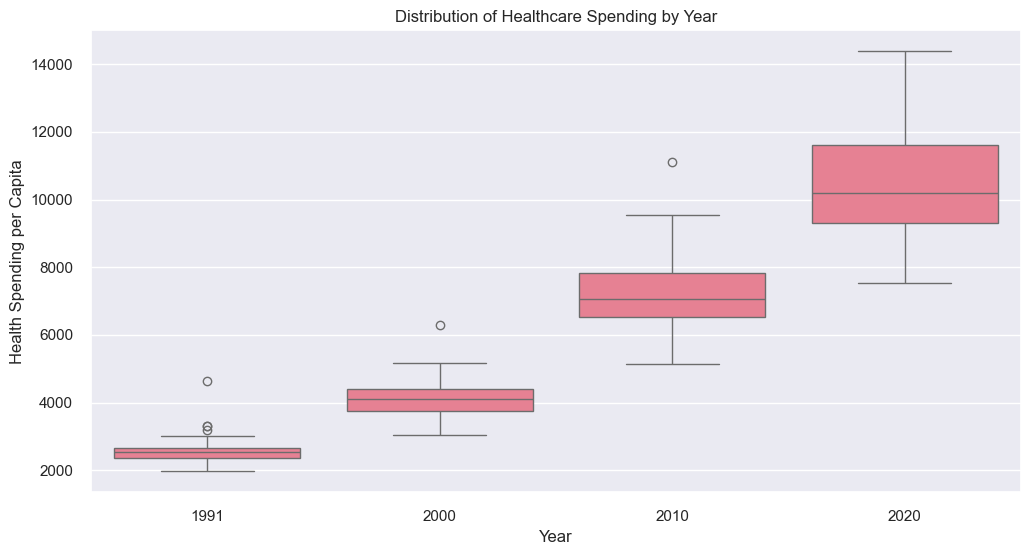

In [7]:
plt.figure(figsize=(12, 6))
df_melt = df_pivot[years].reset_index().melt(id_vars='Location', var_name='Year', value_name='Health Spending per Capita')
sns.boxplot(x='Year', y='Health Spending per Capita', data=df_melt)
plt.title('Distribution of Healthcare Spending by Year')
plt.show()

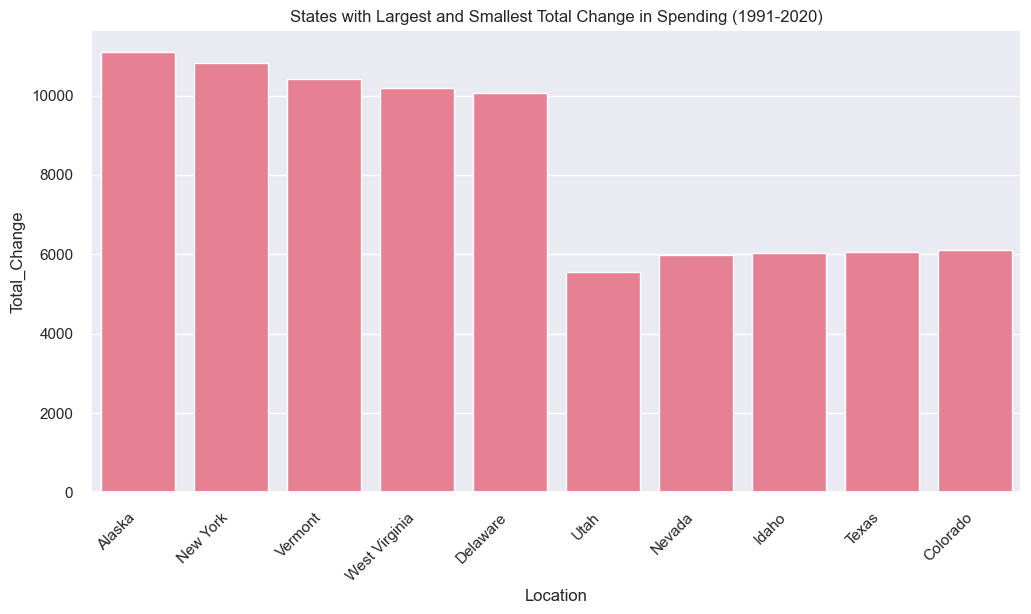

In [8]:
top_bottom = pd.concat([df_pivot.nlargest(5, 'Total_Change'), df_pivot.nsmallest(5, 'Total_Change')])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_bottom.index, y=top_bottom['Total_Change'])
plt.xticks(rotation=45, ha='right')
plt.title('States with Largest and Smallest Total Change in Spending (1991-2020)')
plt.show()

In [9]:
output_dir = '../data/processed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df_pivot.to_csv(os.path.join(output_dir, 'healthcare_spending_analysis.csv'))

# Summary of Healthcare Spending Analysis (1991-2020)

## Overview
This analysis examines the evolution of healthcare spending per capita across U.S. states over a 30-year period, revealing significant trends in healthcare costs and regional disparities.

## Key Findings

### National Trends
- U.S. average healthcare spending per capita increased from **$2,659** in 1991 to **$10,191** in 2020.
- Total national increase: **$7,532** (283.3% growth).
- Compound Annual Growth Rate (CAGR): **4.7%** over 29 years.

### Regional Variations and State-Level Insights

#### Highest Spending States (2020)
1. **District of Columbia**: $14,381
2. **Alaska**: $13,642
3. **Massachusetts**: $13,319
4. **New York**: $14,007
5. **Connecticut**: $12,489

#### Most Significant Growth (1991-2020)
- **Alaska** showed the highest percentage increase, with spending growing over **400%**.
- Western states generally showed higher growth rates despite lower absolute spending.
- Northeastern states maintained consistently high spending throughout the period.

#### Lowest Spending States (2020)
1. **Utah**: $7,522
2. **Idaho**: $8,148
3. **Arizona**: $8,756
4. **Georgia**: $8,758
5. **South Carolina**: $8,766

### Notable Patterns

#### Geographic Disparities
- Persistent regional differences with the **Northeast** consistently showing highest spending.
- Western states maintained lower spending levels but showed rapid growth.
- Significant urban-rural divide in spending patterns.

#### Growth Dynamics
- Spending growth was not uniform across states.
- Larger increases observed in **2000-2010** compared to **2010-2020**.
- States with lower initial spending generally showed higher percentage increases.

### Statistical Insights
- Distribution of spending became more dispersed over time.
- Increasing variance between states suggests growing healthcare cost disparities.
- Strong correlation between urban concentration and higher healthcare spending.

## Implications
1. Healthcare spending shows consistent upward trajectory across all states.
2. Regional disparities persist and in some cases have widened.
3. Cost growth significantly outpaces general inflation.
4. Urban areas consistently show higher per capita spending.

## Recommendations for Further Analysis
1. Investigate factors driving cost variations between states.
2. Examine relationship between spending and healthcare outcomes.
3. Analyze impact of policy changes on spending patterns.
4. Study correlation between demographic factors and healthcare costs.

This analysis provides valuable insights into long-term healthcare spending trends and highlights the need for targeted policy approaches to address regional disparities and cost growth.